*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

# Teoría de la Información - Práctica

## Planteamiento del problema

Disponemos de tres series temporales correspondientes a la respuesta de dos tipos de neuronas, LP y VD$^{(*)}$, ante estados de control, inyección de GABA y recuperación, obtenidas experimentalmente en el laboratorio.

Nuestro objetivo es realizar una codificación adecuada de estas series, suponiendo inicialmente que los eventos que tienen la información son los *spikes* o aumentos rápidos del potencial seguidos de un periodo de hiperpolarización. A partir de esta codificación calcularemos la información mutua entre las respuestas de los dos tipos de neurona, y estudiaremos la transferencia de información entre ellas.

Veamos paso a paso cómo modelamos los datos y resolvemos el problema.

$^{(*)}$Las siglas LP vienen de *Lateral Pyloric neuron* y las siglas VD de *Ventricular Dilator neuron*, ambas presentes en el sistema nervioso estomatogástrico.

## Cargar paquetes

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='svg'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize
import seaborn as sns
from time import time
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import multiprocessing
import contextlib

## Leer archivos

Leemos los tres archivos de los que disponemos, cada uno de ellos correspondientes a las dos series temporales que nos interesan en los estados de control, inyección de GABA y recuperación. Para el estado en inyección de GABA, no consideramos la tercera columna con los valores del tiempo de inyección.

Utilizaremos como estructura de datos un *dataframe* de la librería `Pandas`, que nos permite leer y manejar los datos de forma bastante cómoda.

In [4]:
trozoC = pd.read_csv("TrozoC.txt", names = ["LP", "VD"], 
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [90]:
trozoG = pd.read_csv("TrozoG.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [91]:
trozoR = pd.read_csv("TrozoR.txt", names = ["LP", "VD"], 
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

En primer lugar trabajaremos únicamente con uno de los trozos (`trozoC`), donde detallaremos todas las operaciones y cálculos que hacemos, y posteriormente repetiremos estos cálculos en los otros dos trozos.

## Establecer umbral

El primer paso que debemos realizar es establecer para cada señal un umbral o *threshold* a partir del cual consideraremos que se ha producido un *spike*. Para ello nos basaremos primero en un criterio estadístico para elegir un umbral preliminar, y en vista de los resultados lo ajustaremos manualmente hasta un valor que consideremos razonable.

Para esta primera elección del umbral ($\theta$) se ha seguido un procedimiento de ensayo-error: como primera estrategia, hemos probado a utilizar el rango intercuartílico de la secuencia, esto es, la distancia entre el valor que deja por encima el $75$% de los valores y el que deja el $25$%, multiplicado por $1.5$. El resultado era demasiado conservador, pues consideraba muchos *spikes* que resultaban ser ruido. Por ello, decidimos utilizar la siguiente fórmula:

$$
\theta = 1.5(\mu + 3\sigma),
$$

donde $\mu$ y $\sigma$ son la media y desviación típica de la señal. Utilizamos esta fórmula porque, para una distribución normal, es conocido que el $99.7$% de la densidad se concentra en el intervalo $[\mu - 3\sigma, \mu + 3\sigma]$, y a nosotros solo nos interesa el umbral superior para detectar eventos raros. Aplicamos además un factor corrector de $1.5$ para evitar obtener un umbral demasiado conservador.

In [5]:
def compute_threshold(df):
    """ Calcula el umbral basándose en información estadística
        de las series. """
    
    return 1.5 * (df.mean() + 3 * df.std())

In [6]:
threshold = compute_threshold(trozoC)
threshold

LP    0.369632
VD    0.213745
dtype: float64

Vemos que obtenemos un valor de aproximadamente 0.37 para la serie referente a la neurona LP, y un valor de 0.21 para la neurona VD. Una vez hemos fijado este umbral preliminar, lo aplicamos a las series temporales, sustituyendo los valores que se encuentran por encima de él por $1$ y los que se quedan por debajo con $0$.

In [7]:
def filter_with_threshold(df, threshold):
    """ Transforma las señales en 'df' en señales binarias, según si superan
        o no el umbral 'threshold'. """
    
    return (df > threshold).astype(int)

In [8]:
trozoC_t = filter_with_threshold(trozoC, threshold)

Podemos contar el número de elementos que superan el umbral:

In [9]:
above_t = trozoC_t.sum()
total = trozoC.count()
print("Superan el umbral:")
print(above_t)
print("En porcentaje superan el umbral:")
print((above_t / total) * 100)

Superan el umbral:
LP    131821
VD    149463
dtype: int64
En porcentaje superan el umbral:
LP    0.664163
VD    0.753049
dtype: float64


Vemos que menos del 1% de puntos en ambas señales superan el umbral. Podemos ahora intentar visualizar el efecto que tiene la transformación de la señal a partir del umbral. La siguiente función permite pintar simultáneamente la señal original y la transformada (escalada para poder compararlas).

In [10]:
def compare_signal_and_transformation(df, df_t, threshold):
    """ Muestra dos señales `df` y `df_t` que tengan las mismas dimensiones.
        Se pinta la señal original real-valuada y la señal binaria superpuesta,
        además de la recta horizontal que representa el umbral. """
    
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize = (11, 4))
    
    # Loop over columns
    for j in range(cols):
        axs[j].set_title(list(df)[j])
        
        # Plot original and transformed signal along with threshold
        axs[j].plot(df.iloc[:, j], label = "Original")
        axs[j].plot(df_t.iloc[:, j], label = "Transformada")
        xmin, xmax = axs[j].get_xlim()
        axs[j].plot([xmin, xmax], 2 * [threshold[j]], label = "Umbral")
        axs[j].legend()

Probamos a visualizar los primeros 1000 valores en ambas series.

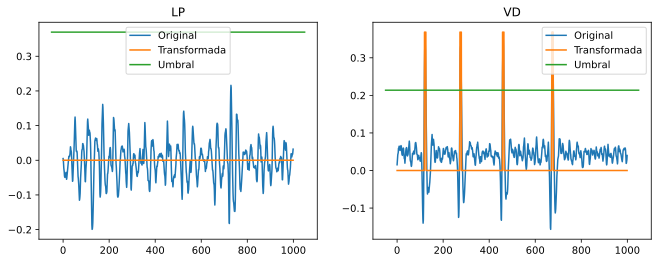

In [11]:
a = 0
b = 1000
compare_signal_and_transformation(trozoC[a:b], 
                                  trozoC_t[a:b] * trozoC[a:b].max(), 
                                  threshold)

Como podemos ver, en la primera serie ningún valor ha superado el umbral en los primeros 1000 puntos. Sin embargo, en la segunda serie se aprecian 4 zonas (potenciales *spikes*) donde se supera el umbral. Si cambiamos el intervalo por ejemplo a $[3000, 3500]$ podemos ver zonas donde se supera el umbral también en la primera señal.

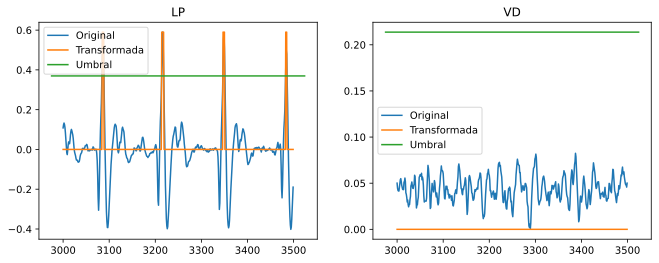

In [12]:
a = 3000
b = 3500
compare_signal_and_transformation(trozoC[a:b], 
                                  trozoC_t[a:b] * trozoC[a:b].max(), 
                                  threshold)

# Calcular picos

El siguiente paso es agrupar todos los 1's consecutivos que forman parte de un mismo spike en un único valor. Para ello, utilizamos la función `find_peaks` de la librería `scipy`, la cual computa todos los máximos locales de su argumento (en caso de existir varios máximos consecutivos con el mismo valor, devuelve solo el valor central eventualmente truncado). Al utilizarla sobre nuestra serie de 0's y 1's, obtenemos una nueva serie con los puntos medios de las agrupaciones de 1's activados, y el resto a 0.

In [13]:
def get_peaks(df):
    """ Busca los picos correspondientes a cada columna del 
        dataframe utilizando 'find_peaks'. Esta se queda con 
        el valor medio de picos consecutivos. """
   
    # Get number of columns
    cols = df.shape[1] if len(df.shape) > 1 else 1
    
    # Return peaks array
    return np.array([find_peaks(df.iloc[:, index])[0] 
                     for index in range(cols)], dtype = object)

El número total de spikes encontrados (de forma absoluta y en porcentaje) es:

In [14]:
peaks = get_peaks(trozoC_t)
peaks_lp = len(peaks[0])
peaks_vd = len(peaks[1])
print(f"Número de spikes:\nLP: {peaks_lp}\nVD: {peaks_vd}")
print(f"% de spikes:\nLP: {100 * peaks_lp / total[0]:.3f}%")
print(f"VD: {100 * peaks_vd / total[1]:.3f}%")

Número de spikes:
LP: 31228
VD: 22306
% de spikes:
LP: 0.157%
VD: 0.112%


Vemos que el número de *spikes* finalmente considerados apenas supera el $0.1$% de puntos de la serie original. Podemos pintar la serie original junto con los spikes considerados.

In [15]:
def compare_signal_and_peaks(df, peaks):
    """ Muestra la señal original junto con los picos considerados. """
    
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(11,4))
    
    # Loop over columns
    for j in range(cols):
        axs[j].set_title(list(df)[j])
        
        # Get peaks for each column
        axs[j].plot(df.iloc[:, j])
        axs[j].plot(peaks[j], df.iloc[peaks[j], j], "o")

Observamos los resultados en los primeros 10000 valores, viendo que los *spikes* visibles han sido correctamente capturados.

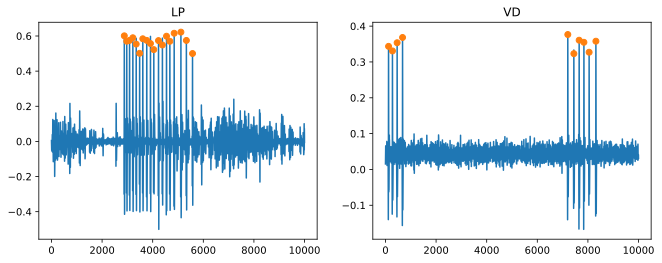

In [16]:
compare_signal_and_peaks(trozoC[0:10000], get_peaks(trozoC_t[0:10000]))

Finalmente, podemos "hacer zoom" en un *spike* concreto y ver exactamente cómo se comporta nuestra transformación. Dibujaremos la serie original, la serie binaria preliminar, la recta del umbral, y finalmente los puntos que se convertirán en picos. Lo hacemos por ejemplo para la primera serie.

In [17]:
def compare_signal_transformation_and_peaks(df, df_t, peaks, threshold, j, 
                                            title, offset = 0):
    """ Compara la j-ésima (j = 0,1) señal original, la transformada, los 
        picos encontrados y el umbral. Comienza en la posición 'offset'. """
    
    # Get peaks for each column
    plt.plot(df.iloc[:, j], label = "Original")
    plt.plot(df_t.iloc[:, j], label = "Transformada")
    
    # Plot information
    xmin, xmax = plt.xlim()
    plt.plot([xmin, xmax], 2 * [threshold[j]], label = "Umbral")
    plt.plot(offset + peaks[j], df.iloc[peaks[j], j], "o", label = "Picos")
    plt.title(title)
    plt.legend()

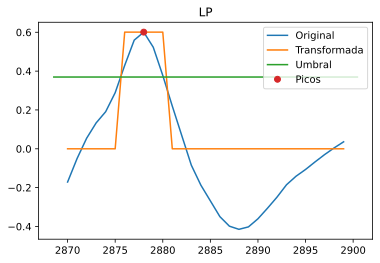

In [18]:
a = 2870
b = 2900
compare_signal_transformation_and_peaks(trozoC[a:b], 
                                        trozoC_t[a:b] * trozoC[a:b].max(),
                                        get_peaks(trozoC_t[a:b]), threshold, 
                                        j = 0, title = "LP", offset = a)

## Calcular tamaño de bin

El siguiente paso es elegir una resolución para nuestra serie, esto es, un tamaño de ventana o *bin* $\Delta t$ que represente el intervalo mínimo de medición. Buscamos que este valor sea lo suficientemente pequeño como para que en un *bin* no pueda haber más de un *spike*, de forma que nuestro cálculo posterior esté bien definido. El valor de $\Delta t$ debe ser el mismo en las dos series LP y VD.

Para establecer este valor, calculamos la distancia mínima entre *spikes* en las dos series, y tomaremos como $\Delta t$ el mínimo entre los dos valores resultantes.

In [19]:
def min_distance_between_peaks(peaks):
    """ Calcula la distancia mínima entre picos para una serie, el índice
        donde se alcanza y el array completo de distancias entre picos. """
    
    dist = np.diff(peaks)
    min_index = np.argmin(dist)
    
    return dist[min_index], min_index, np.array(dist)

In [20]:
# Get min distance information for both series
min_dist_info = np.array([min_distance_between_peaks(p) for p in peaks], 
                         dtype = object)

# Select window accordingly
window = min(min_dist_info[:, 0])

print("Distancia mínima y pico donde se alcanza en cada serie:")
print(f"{min_dist_info[:, 0:2]}")
print("Ventana seleccionada:", window)

Distancia mínima y pico donde se alcanza en cada serie:
[[23 3579]
 [8 13286]]
Ventana seleccionada: 8


Podemos estudiar en cada caso las posiciones de los picos más cercanos dentro de la propia serie.

In [21]:
min_peak_position = min_dist_info[:, 1]
min_peak_position = [[peaks[i][min_peak_position[i]], 
                      peaks[i][min_peak_position[i] + 1]] 
                     for i in range(len(peaks))]
print("Posiciones de los picos más cercanos en LP y VD, respectivamente:")
print(f"{min_peak_position}")

Posiciones de los picos más cercanos en LP y VD, respectivamente:
[[2142183, 2142206], [12346071, 12346079]]


Pintamos ahora las series temporales con la rejilla formada al dividir en ventanas del tamaño elegido. Escogemos en cada caso un intervalo que refleje los dos *spikes* más cercanos, aquellos que han provocado que elijamos así el tamaño de ventana.

In [22]:
def plot_window(df, window, peak_position):
    """ Muestra las series junto con la rejilla formada por las ventanas.
        El intervalo será un entorno correspondiente a los spikes 
        más cercanos en cada caso, que se reciben como parámetro. """
    
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize = (11,4))
    
    for j in range(cols):
        axs[j].set_title(list(df)[j])
        axs[j].ticklabel_format(style = 'sci', scilimits = (0,0))
        
        # Get peaks for each column
        axs[j].plot(df.iloc[peak_position[j][0]-50:peak_position[j][1]+50, j], 
                        color = "blue", label = "Original")        
        axs[j].plot(peak_position[j][0], df.iloc[peak_position[j][0], j], 
                        "o", color = "red", label = "Picos")
        axs[j].plot(peak_position[j][1], df.iloc[peak_position[j][1], j], 
                        "o", color = "red")
        
        # Plot windowed series
        xlims = [int(np.round(a)) for a in axs[j].get_xlim()]
        offset = int(window * np.round(xlims[0] / window)) 
        axs[j].vlines([offset + i 
                       for i in range(0, xlims[1] - xlims[0], window)], 
                       *axs[j].get_ylim(), color = "orange", label = "Ventana")
        
        axs[j].legend()

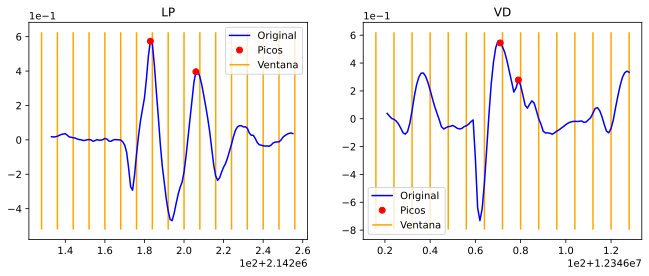

In [23]:
plot_window(trozoC, window, min_peak_position)

Podemos ver en la gráfica de la derecha que los dos *spikes* más cercanos parecen formar parte de un único pico; es decir, se han tomado como *spikes* diferentes debido al ruido en la señal. Intentaremos corregir esta circunstancia aumentando ligeramente el umbral para la segunda serie.

Finalmente, podemos hacer un histograma con todas las distancias entre picos, de forma que visualicemos el comportamiento global de los mismos. En lugar de pintar todas las distancias, pintamos solo aquellas hasta el percentil 90 para no distorsionar la figura con distancias poco frecuentes.

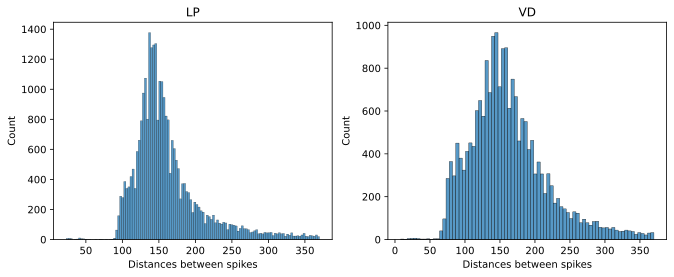

In [24]:
# Get arrays of distances
dist_arr = min_dist_info[:, 2]
fig, axs = plt.subplots(1, 2, figsize = (11, 4))
axs[0].set_title("LP")
axs[1].set_title("VD")
for ax in axs:
    ax.set_xlabel("Distances between spikes")

# Plot histogram of distances up to a threshold
percentile = np.min([np.percentile(dist_arr[i], 90) 
                     for i in range(len(dist_arr))])
sns.histplot(data = dist_arr[0][dist_arr[0] < percentile], ax = axs[0])
sns.histplot(data = dist_arr[1][dist_arr[1] < percentile], ax = axs[1])
plot = plt.plot()

Observamos que al quedarnos simplemente con la mínima distancia estamos siendo demasiado restrictivos. Los picos que se encuentran tan cercanos parecen ser *outliers* a la luz del histograma anterior. Un tamaño de ventana demasiado pequeño puede hacernos perder información mutua entre las series, por lo que vamos a proceder a ignorar estos picos que no presentan un buen comportamiento, y recalcularemos la ventana sin tenerlos en cuenta.

## Rehacer codificación con cambio de umbral y ventana

Tras el estudio de las distancias que hicimos anteriormente, decidimos no tener en cuenta para el cálculo de la ventana los picos cuya distancia es menor que 60. Como para estos últimos habrá colisiones, consideraremos como un único *spike* el caso en que haya uno o más 1's en la serie.

Por otro lado, decidimos aumentar ligeramente el umbral en la segunda serie. Esta decisión parece justificada también a la vista del siguiente histograma de valores de las series.

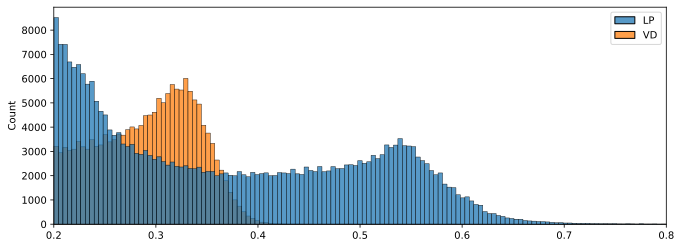

In [42]:
plt.figure(figsize = (11, 4))
ax = sns.histplot(trozoC[(trozoC > 0.2) & (trozoC < 0.8)])
ax.set_xlim(0.2, 0.8)
plt.show()

Vemos que para la serie VD, la mayoría de valores están por encima del umbral fijado previamente (~$0.2$), cosa que no nos interesa. Podemos subirlo por ejemplo hasta un valor de $0.3$ para dejar más puntos por debajo, de forma que  intentamos capturar mejor los *spikes* y solucionar el problema de ruido en los picos que vimos antes. Aplicaremos este cambio junto con el cambio de ventana que comentábamos.

En primer lugar, definimos una función que dado una longitud de serie y un vector con posiciones de los picos, aplica la ventana especificada transformando la serie según esa resolución.

In [25]:
def apply_window(lenght, peaks, window):
    """ Crea un vector de enteros representando la existencia de spikes 
        en la ventana prefijada de una serie temporal. Se devuelve en cada 
        ventana el número de spikes que caen en ella.
        
        Argumentos:
          - lenght: longitud de la serie temporal original.
          - peaks:  posición de los spikes en la serie temporal original.
          - window: tamaño de ventana. """
    
    # Initialize the new sequence with suitable length
    serie_w = np.zeros(math.ceil(lenght / window))
    
    # Get indices of each spike after applying the window
    peaks_idx = [math.floor(p / window) for p in peaks]
    
    # Compute the peaks on each window
    for i in peaks_idx:
        serie_w[i] += 1
    
    return serie_w

La siguiente función captura el cambio manual en el umbral junto con el aumento del tamaño de ventana. La escribimos de forma suficientemente general para poder reutilizarla posteriormente.

In [26]:
def codify_signal(df = None, df_t = None, peaks = None, threshold = None, 
                  window = None, plot = False, peaks_min_dist = None, 
                  compute_collisions = False):
    """ Codifica dos señales real-valuadas en señales binarias, aplicando un 
        umbral y una resolución concreta (tamaño de ventana).
    
        Entrada
        ==========
        df: dataframe con las series temporales originales, en su caso.
        df_t: dataframe con las series tras aplicar el umbral, en su caso.
        peaks: array con las posiciones de los picos tras aplicar el umbral, 
          en su caso.
        threshold: valor del umbral a aplicar. Si es None se calcula uno 
          por defecto.
        window: ventana a aplicar a la serie.
        plot: controla si se muestra un ejemplo de gráfica de la serie con 
          la ventana aplicada.
        peaks_min_dist: valor mínimo a partir del cual considerar la distancia 
          entre picos.
        compute_collisions: controla si se calculan las colisiones en cada 
          ventana.
        
        Salida
        ==========
        - La serie binaria codificada tras aplicar el umbral y la ventana. 
          Aunque haya colisiones, se sigue considerando un único spike.
        - El tamaño de ventana fijado.
        - (Opcional) El número de colisiones encontrado en cada ventana. """
    
    if df is None and df_t is None:
        print("[Error] Se debe proporcionar al menos un dataframe.")
        return None, None
    
    if df_t is None:
        # Compute threshold
        if threshold is None:
            threshold = compute_threshold(df)
        
        # Apply threshold
        df_t = filter_with_threshold(df, threshold)
        
    # Get peaks
    if peaks is None:
        peaks = get_peaks(df_t)
    
    # Compute window as the minimum distance between spikes
    if window is None:
        min_dist_info = np.array([min_distance_between_peaks(p) for p in peaks], 
                                 dtype = object)
        dist_arr = min_dist_info[:, 2]
        window = np.min(min_dist_info[:, 0])

        # Recompute window ignoring the elements with distance less than 
        # 'peaks_min_dist'.
        if peaks_min_dist is not None:
            peaks_to_erase = [np.where(d < peaks_min_dist)[0] for d in dist_arr]
            peaks_new = [np.delete(peaks[0], peaks_to_erase[0]), 
                         np.delete(peaks[1], peaks_to_erase[1])]
            min_dist_info = np.array([min_distance_between_peaks(p) 
                                      for p in peaks_new], dtype = object)
            window = np.min(min_dist_info[:, 0])

        # Show the effect of windowing in the series
        if plot:
            min_peak_position = min_dist_info[:, 1]
            min_peak_position = [[peaks[i][min_peak_position[i]], 
                                  peaks[i][min_peak_position[i] + 1]] 
                                 for i in range(len(peaks))]
            plot_window(df, window, min_peak_position)
    
    # Pseudo-codified, integer-valued signal (takes collisions into account)
    df_w = np.array([apply_window(df_t.shape[0], peaks[i], window) 
                     for i in range(df_t.shape[1])])
    
    # Compute collisions on each window
    count = None
    if compute_collisions:
        unique, count = np.unique(df_w, return_counts = True)
        count = np.sum(unique[unique > 1] * count[unique > 1])
    
    # Recover binary series by ignoring collisions
    df_w[df_w > 1] = 1
    
    return df_w, window, count

Aplicamos entonces el nuevo umbral, y elegimos el tamaño de ventana considerando la distancia mínima entre *spikes* solo a partir de 60, debido a la información visualizada anteriormente en el histograma de distancias.

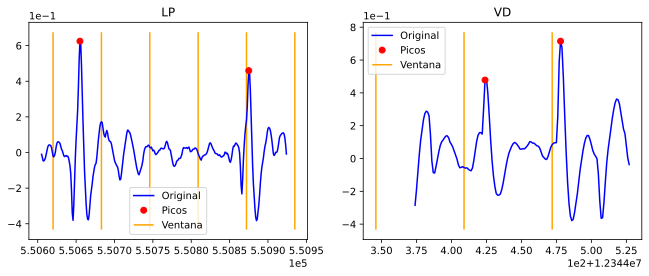

In [27]:
threshold = [threshold[0], 0.3]
trozoC_w, window, _ = codify_signal(trozoC, threshold = threshold, 
                                    window = None, plot = True, 
                                    peaks_min_dist = 60)

Podemos comprobar la reducción de tamaño en la serie tras aplicar la ventana, observando que tenemos una serie con menos del $2$% del tamaño original. Además, los picos más cercanos (figura de arriba) ya sí están bien diferenciados en *spikes* distintos.

In [28]:
print("Nuevo tamaño de ventana:", window)
print("La nueva longitud de la serie es:", len(trozoC_w[0]))
print("Porcentaje del tamaño original: ", end = "")
print(f"{100 * len(trozoC_w[0]) / trozoC.shape[0]:.3f}%")

Nuevo tamaño de ventana: 63
La nueva longitud de la serie es: 315043
Porcentaje del tamaño original: 1.587%


## Calcular información mutua

Para calcular la información mutua, consideramos una ventana deslizante de $b$ bits que determinará los distintos estados posibles de la distribución implícita en las series. Así, en primer lugar convertiremos la serie binaria a una serie de estados, que llamaremos `X_window` en el código, según el número $b$ de bits deseado. Por ejemplo, si `b=2` y tenemos nuestras dos series en un array `X`, tendremos:

$$
\text{X} = \binom{0010\dots}{1100\dots} \implies \text{Xwindow} = \Bigg[ \binom{00}{11}\binom{01}{10}\binom{10}{00} \dots\Bigg]
$$

Las probabilidades que intervienen en el cálculo se computarán mediante su frecuencia de ocurrencia; es decir, para cada posible estado se cuenta el número de veces que aparece y se divide por el número total de estados observados.

Implementaremos el cálculo de la información mutua con dos estrategias distintas.

### A partir de la entropía

Recordamos que la información mutua de las dos series $MI(X, Y)$ puede descomponerse como:

$$MI(X,Y)=H(X)+H(Y)-H(X, Y),$$

donde $H$ representa la entropía. En concreto,

$$H(X)=-\sum_{x}p(x)\log_2(p(x))\quad \text{y} \quad H(X,Y)=-\sum_{xy}p(x,y)\log_2(p(x,y)).$$

A nivel de implementación es muy sencillo: una vez hemos pasado la ventana y tenemos los estados (ya sean individuales o conjuntos), llamamos a la función `np.unique` que nos devuelve los estados únicos y su frecuencia de ocurrencia. Calculamos las probabilidades como comentábamos antes y simplemente aplicamos la fórmula. El cálculo es rápido ya que se aprovecha de la vectorización de la librería `numpy`.

### A partir de la fórmula

En este caso utilizaremos directamente la fórmula

$$
MI(X,Y)=\sum_{xy}p(x,y)\log_2\left( \frac{p(x,y)}{p(x)p(y)}\right).
$$

Como vemos, este enfoque requiere calcular tanto las probabilidades conjuntas como las probabilidades individuales de cada serie. Esto supone un problema adicional, pues puede darse el caso de que haya estados en las series individuales que no aparezcan juntos en la serie conjunta, de forma que no contribuirán al cálculo de la información mutua.

En cualquier caso, queremos realizar el cómputo de manera vectorial para reducir el tiempo de ejecución. Lo primero que hacemos es calcular los estados únicos y sus probabilidades tanto de la serie conjunta como de las series individuales, utilizando de nuevo la función `np.unique`. Llamaremos a los vectores de estados observados $u, u_x$ y $u_y$, y a los vectores de probabilidades $p, p_x$ y $p_y$. Nos gustaría poder calcular la información mutua calculando el vector correspondiente a hacer las operaciones elemento a elemento:

$$
MI(X, Y) = \sum p \log_2\left(\frac{p}{p_x \times p_y}\right),
$$

donde $\times$ simboliza el producto cartesiano. Sin embargo, como comentábamos antes es posible que alguno de los estados en $u_x\times u_y$ no se vea materializado en ningún estado conjunto de $u$ (por ejemplo, el estado conjunto $[(1 1), (1 1)]\in u_x \times u_y$ será muy difícil de observar en $u$, ya que aunque podamos observar dos *spikes* seguidos en las series individuales, será muy raro que ocurra en las dos series a la vez). Es decir, es posible que el vector $p$ no tenga la misma dimensión que $p_x\times p_y$.

Para solucionar esto, construimos en primer lugar un vector $u_{xy}$ que contenga todos los elementos de $u_x\times u_y$, sean o no observados en $u$. Después, compararemos este vector con el vector $u$ (ayudándonos de las funciones de `numpy`), construyendo así una máscara $m$ que localize los elementos discordantes. Por tanto, tendremos

$$u_{xy}[m]=u.$$

Finalmente, aplicamos esta máscara al vector $p_{xy}$ que contiene las probabilidades de $u_{xy}$ para quedarnos únicamente con las probabilidades que nos interesan.

En primer lugar implementamos una función que calcula la entropía de una o varias series (en el segundo caso se entiende que es la entropía conjunta).

In [29]:
def H(X, bs = [1]):
    """ Calcula la entropía de la serie X (vista como M series 
        unidimensionales) con ventanas de palabras de tamaños especificados 
        en 'bs'.
        
        Entrada
        ==========
        X: numpy array con tamaño (M, N), donde M es el número de series 
          unidimensionales y N el número de observaciones. Si solo hay una 
          serie,  debe ser de tamaño (1, N). Si M > 1, se calcula la entropía 
          conjunta.
        bs: lista con tamaños de ventanas de palabras.
        
        Salida
        ==========
        Array con el cálculo de la entropía para cada tamaño de palabra. """
    
    Hs = np.empty(len(bs))
        
    for j, b in enumerate(bs):
        # Pasar una ventana deslizante de tamaño 'b' por todas las series
        X_window = np.array([X[:, i:i+b] for i in range(X.shape[1] - b)])

        # Calcular el número de estados que se observan y sus probabilidades
        states, counts = np.unique(X_window, axis = 0, return_counts = True)
        probs = counts / np.sum(counts)
        
        # Calcular la entropía utilizando su fórmula
        h = -np.sum(probs * np.log2(probs))
        Hs[j] = h
    
    return Hs

Ahora implementamos una función que calcula la información mutua de las dos series, así como la entropía individual de cada serie (que necesitaremos para calcular después la transferencia de información). Esta función permite elegir la estrategia de cálculo entre las dos que hemos comentado.

In [30]:
def MI_and_H(X, bs = [1], strategy = "from_entropy"):
    """ Calcula la información mutua entre dos series temporales y sus 
        entropías individuales, utilizando distintos tamaños de ventanas 
        de palabras.
        
        Entrada
        ==========
        X: numpy array con tamaño (2, N), donde N es el número de 
          observaciones.
        bs: lista con tamaños de ventanas de palabras.
        strategy: puede ser "direct" para calcular la información mutua 
         a partir de su definición, o "from_entropy" para calcularla 
         usando la fórmula que la relaciona con las entropías.
        
        Salida
        ==========
        Arrays con el cálculo de la información mutua y la entropía de cada 
        serie, para cada tamaño de palabra. """
    
    if strategy == "from_entropy":
        HsX = H(X[0].reshape(1, -1), bs)
        HsY = H(X[1].reshape(1, -1), bs)
        Ms = HsX + HsY - H(X, bs)
        
        return Ms, HsX, HsY
    
    elif strategy == "direct":
        HsX = np.empty(len(bs))
        HsY = np.empty(len(bs))
        Ms = np.empty(len(bs))
                          
        for j, b in enumerate(bs):
            # Pasar una ventana deslizante de tamaño 'b' por todas las series
            X_window = np.array([X[:, i:i+b] for i in range(X.shape[1] - b)])

            # Calcular el número de estados que se observan y sus probabilidades
            states_xy, counts_xy = np.unique(X_window, axis = 0, 
                                             return_counts = True)
            probs_xy = counts_xy / np.sum(counts_xy)

            # Calculamos todos los estados individuales de cada serie y sus 
            # probabilidades, guardando la información en arrays con dos filas 
            # (una por cada serie)
            states_marginal = []
            probs_marginal = []
            for i in range(X.shape[0]):
                states, counts = np.unique(X_window[:, i], axis = 0, 
                                           return_counts = True)
                states_marginal.append(states)
                probs_marginal.append(np.array(counts / np.sum(counts)))

            # Calculamos todos los posibles productos de probabilidades de 
            # estados marginales que podrían ser observados
            possible_products_probs = np.outer(probs_marginal[0], 
                                               probs_marginal[1]).flatten()

            # Creamos una máscara para eliminar de los productos anteriores 
            # aquellos correspondientes a estados que no fueron observados de 
            # forma conjunta
            possible_states = np.array([np.array([sx, sy]) 
                                        for sx in states_marginal[0] 
                                        for sy in states_marginal[1]])
            mask = ((possible_states[:, None, :, :] == states_xy)
                    .all(2)).all(2).any(1)
            
            # Calculamos la información mutua y las entropías individuales
            M = np.sum(probs_xy 
                       * np.log2(probs_xy / possible_products_probs[mask]))
            HX = -np.sum(probs_marginal[0] * np.log2(probs_marginal[0]))
            HY = -np.sum(probs_marginal[1] * np.log2(probs_marginal[1]))
            
            # Guardamos los resultados
            Ms[j] = M
            HsX[j] = HX
            HsY[j] = HY
            
        return Ms, HsX, HsY
    
    else:
        print("[Error] La estrategia de cálculo debe ser ", end="")
        print("\"from_entropy\" ó \"direct\".")
        
        return None, None, None

Escribimos una función para calcular la información mutua entre las series, permitiendo elegir la estrategia y midiendo los tiempos, lo que nos permitirá comparar ambas implementaciones. También calculamos lo que se conoce como *información mutua normalizada*, que se puede entender como una medida de la transferencia de información entre estímulo y respuesta. En general, para un estímulo $S$ y una respuesta $R$, la transferencia de información del estímulo a la respuesta se puede calcular como

$$
E_{S\to R} = \frac{MI(S, R)}{H(S)}.
$$

Este valor oscila en $[0,1]$, pues $H(S)$ representa la cantidad máxima de información que se puede transmitir del estímulo a la respuesta.

In [31]:
def compute_info(series, bs, strategy, name, verbose = True):
    """ Calcula la información mutua, la entropía individual y conjunta 
        y la transferencia de información entre dos series para distintos 
        tamaños de palabra, con la estrategia de cálculo especificada. 
        Imprime el tiempo de ejecución y opcionalmente los resultados. """
    
    start = time()
    Ms, HsX, HsY = MI_and_H(series, bs, strategy)
    TXYs = Ms / HsX
    TYXs = Ms / HsY
    print(f"Tiempo total para estrategia {strategy}: {(time() - start):.1f}s")
    
    if verbose:
        print(f"Estadísticas de información con estrategia {strategy}:")
        for b, m, hx, hy, txy, tyx in zip(bs, Ms, HsX, HsY, TXYs, TYXs):
            print(f"[b = {b}]")
            print(f"  MI = {m:.5f}")
            print(f"  H(LP) = {hx:.5f}")
            print(f"  H(VD) = {hy:.5f}")
            print(f"  Transferencia LP-->VD = {txy:.5f}")
            print(f"  Transferencia VD-->LP = {tyx:.5f}")
    
    return Ms, TXYs, TYXs, HsX, HsY

También definimos un par de funciones para mostrar gráficamente los resultados.

In [32]:
def plot_I(info, bs, title, ax = None, color = 'b'):
    """ Muestra una gráfica de la medida de información proporcionada
        en función del tamaño de palabra. """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(bs, info, color = color)
    ax.set_xlabel("Tamaño de palabra")
    ax.set_title(title)

In [62]:
def plot_info(name, bs, Ms, HsX, HsY, TXYs, TYXs):
    """ Muestra gráficas de la información mutua, las entropías, y la 
        transferencia de información entre dos series, para distintos tamaños 
        de palabra. """
    
    fig, axs = plt.subplots(2, 2, figsize = (11, 10))
    fig.suptitle(name)
    
    # Plot entropies
    HsXY = HsX + HsY - Ms
    axs[0, 0].set_title("Entropías")
    axs[0, 0].set_xlabel("Tamaño de palabra")
    axs[0, 0].plot(bs, HsX, label = "H(X)")
    axs[0, 0].plot(bs, HsY, label = "H(Y)")
    axs[0, 0].plot(bs, HsXY, label = "H(X, Y)")
    axs[0, 0].legend()
    
    # Plot information and transference
    plot_I(Ms, bs, "Información mutua LP<-->VD", axs[0, 1])
    plot_I(TXYs, bs, "Transferencia LP-->VD", axs[1, 0], 'red')
    plot_I(TYXs, bs, "Transferencia VD-->LP", axs[1, 1], 'orange')

Calculamos por fin la información mutua de las series LP y VD, utilizando tamaños de palabra variando en $\{1,\dots, 8\}$. De paso, comprobamos que se obtiene el mismo resultado con las dos estrategias implementadas, y con tiempos de ejecución similares.

Dibujamos la información mutua obtenida en función del tamaño de palabra, así como la transferencia de informacion $LP\to VD$ y viceversa, también en función del tamaño de palabra. 

Tiempo total para estrategia from_entropy: 27.1s
Estadísticas de información con estrategia from_entropy:
[b = 1]
  MI = 0.00846
  H(LP) = 0.46600
  H(VD) = 0.35380
  Transferencia LP-->VD = 0.01816
  Transferencia VD-->LP = 0.02392
[b = 2]
  MI = 0.03692
  H(LP) = 0.92702
  H(VD) = 0.70739
  Transferencia LP-->VD = 0.03982
  Transferencia VD-->LP = 0.05219
[b = 3]
  MI = 0.06384
  H(LP) = 1.31255
  H(VD) = 1.01641
  Transferencia LP-->VD = 0.04864
  Transferencia VD-->LP = 0.06281
[b = 4]
  MI = 0.07785
  H(LP) = 1.61041
  H(VD) = 1.25354
  Transferencia LP-->VD = 0.04834
  Transferencia VD-->LP = 0.06210
[b = 5]
  MI = 0.08787
  H(LP) = 1.88619
  H(VD) = 1.46183
  Transferencia LP-->VD = 0.04658
  Transferencia VD-->LP = 0.06011
[b = 6]
  MI = 0.09674
  H(LP) = 2.14488
  H(VD) = 1.65459
  Transferencia LP-->VD = 0.04510
  Transferencia VD-->LP = 0.05847
[b = 7]
  MI = 0.10581
  H(LP) = 2.39155
  H(VD) = 1.84048
  Transferencia LP-->VD = 0.04424
  Transferencia VD-->LP = 0.05749
[b = 

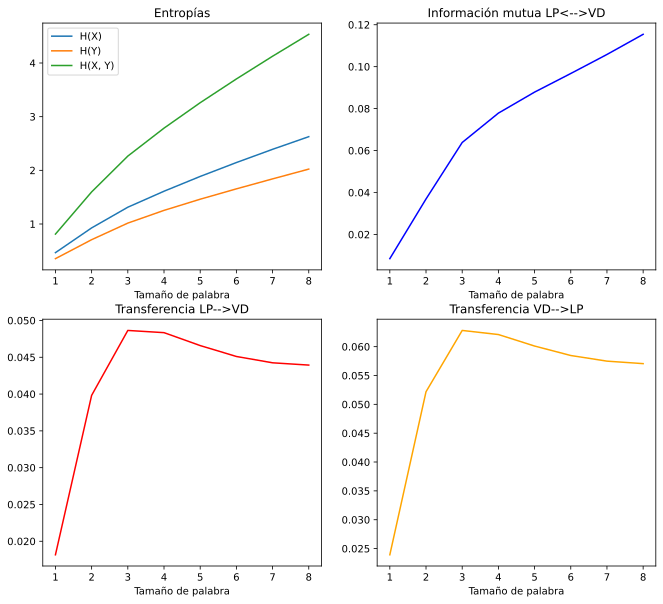

In [98]:
bs = np.arange(1, 9, 1)
Ms_entropy, TXYs, TYXs, HsX, HsY = \
    compute_info(trozoC_w, bs, "from_entropy", "trozoC")
Ms_direct, _, _, _, _ = compute_info(trozoC_w, bs, "direct", "trozoC", 
                                     verbose = False)

if np.allclose(Ms_entropy, Ms_direct):
    print("Ambas estrategias proporcionan los mismos resultados.")
        
plot_info("trozoC", bs, Ms_entropy, HsX, HsY, TXYs, TYXs)

La evolución de la información mutua con respecto al tamaño de palabra parece bastante clara: la IM crece conforme aumenta el número de bits de palabra, al menos en el rango $b\in[1,8]$. A partir de $b=3$ parece que decrece la velocidad con la que aumenta la IM, llegando al valor máximo de casi $0.12$ para tamaño de palabra 8. Esto se puede observar también en la primera gráfica sobre las entropías, donde vemos que a partir de $b=3$ se produce también un descenso en las pendientes.

En cuanto a la transferencia de información, sabemos que en general $E_{S\to R}=0$ implica que toda la información se pierde, mientras que $E_{S\to R}=1$ implica que hay una completa sincronización entre estímulo y respuesta. En nuestro caso, $E_{LP\to VD}$ queda un poco por debajo de $E_{VD\to LP}$ para todos los tamaños de palabra, y ambas tienen valores pequeños (pues la MI es pequeña en comparación con las entropías). Sin embargo, ninguna es 0, por lo que podemos afirmar que hay transferencia de información en ambos sentidos, siendo esta transferencia ligeramente mayor desde la neurona VD a la LP. 

En ambos casos podemos observar que la máxima transferencia se obtiene para un tamaño de palabra de 3 bits, y que a partir de este momento empieza a decrecer. Como hemos dicho que para estas series la información mutua crece con el tamaño de palabra, la conclusión a la que llegamos es que la entropía individual de cada serie aumenta a un ritmo más rápido que la información mutua a partir de un tamaño de palabra de 3 bits, por lo que tendemos a una peor sincronización conforme aumentamos el número de bits a partir de ese umbral.

## Buscar el tamaño óptimo de bin y palabra

Una vez que hemos hecho todo el estudio de la información en `trozoC` eligiendo un tamaño de bin, nos preguntamos cómo evoluciona la información mutua no solo al cambiar el tamaño de palabra, sino también al cambiar el tamaño de bin. Lo que haremos ahora es ir variando el tamaño de bin desde 5 hasta 600, aumentando de 5 en 5 cada vez, y estudiaremos gráficamente lo que le ocurre a la información mutua para cada tamaño de palabra. También mostraremos una medida de IM normalizada, obtenida al dividir la información mutua por el tamaño de bin y de palabra, para poder comparar los resultados entre todos los tamaños de bin y de palabra.

En esta situación tendremos un problema que antes, por diseño, no ocurría. Hablamos de las *colisiones*, es decir, situaciones en las que en una ventana tengamos más de un *spike*. En estos casos el cálculo tal y como lo habíamos planteado no tendría sentido, por lo que dejaremos igualmente a $1$ aquellas ventanas donde haya más de un *spike*. Sin embargo, sí que mantendremos paralelamente un registro del número total de colisiones que se producen, y veremos cómo evoluciona en función del tamaño de bin.

Debido a que este cálculo va a ser computacionalmente exigente, desarrollamos un código que permita hacer las ejecuciones en paralelo, aprovechando todos los núcleos de la máquina donde se ejecute. Para ello definimos en primer lugar la función que se encargará de calcular la información mutua y las colisiones variando el tamaño de bin y con un tamaño de palabra fijo.

In [67]:
def process_word(b, n, df_t, peaks):
    """ Compute MI and collisions for varying window sizes, for a given 
        word size 'b'. """
    
    MIs = []
    cs = []
    
    for w in np.arange(5, n + 1, 5):
        df_w, _, collisions = \
            codify_signal(df_t = trozoC_t, peaks = peaks, window = w, 
                          compute_collisions = True)
        MIs.append(MI_and_H(df_w, [b])[0][0])
        cs.append(collisions)
        
    return MIs, cs, b

Creamos un *callback* para obtener una barra de progreso cuando hagamos la llamada paralela, que nos diga los trabajos que se van completando y el tiempo que tardan.

In [68]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallBack(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n = self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallBack
    
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  

Ejecutamos nuestra función con los parámetros adecuados.

In [69]:
trozoC_t = filter_with_threshold(trozoC, threshold)
peaks = get_peaks(trozoC_t)
n = 600
bs = np.arange(1, 9)

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores) \
              (delayed(process_word)(b, n, trozoC_t, peaks) for b in bs)

Mostramos los resultados obtenidos. Pintamos para cada tamaño de palabra la gráfica de las colisiones, aunque esta última no dependa del tamaño de palabra, para poder comparar más fácilmente en cada fila.

ValueError: x and y must have same first dimension, but have shapes (2000,) and (120,)

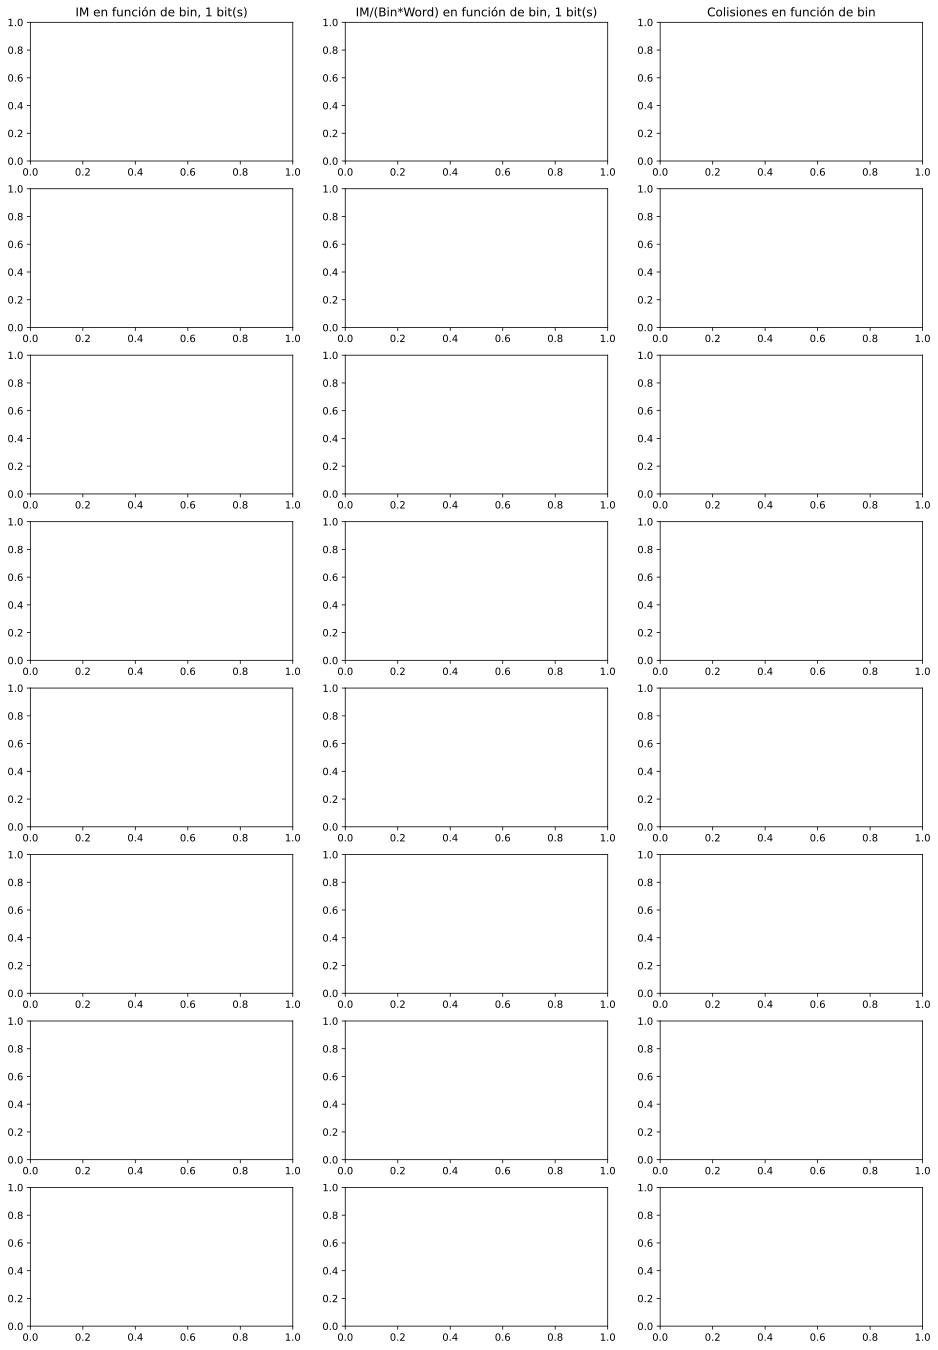

In [86]:
fig, axs = plt.subplots(8, 3, figsize = (16, 24))
for i, r in enumerate(results):
    b = r[2]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s)")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s)")
    axs[i, 2].set_title(f"Colisiones en función de bin")
        
    axs[i, 0].plot(np.arange(5, n + 1, 5), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 5), r[0] /(np.arange(5, n + 1, 5) * b), 
                   color = "red")
    axs[i, 2].plot(np.arange(5, n + 1, 5), r[1], color = "orange")

Vemos que el comportamiento de la IM en función de la ventana es uniforme para todos los tamaños de palabra: en este caso, **la información mutua crece conforme aumentamos el tamaño de bin**. Al tratar las colisiones de la forma en que lo hacemos, cuando aumentamos el tamaño de bin provocamos que haya más posibilidades de encontrar eventos relevantes en la serie conjunta (por ejemplo, más probabilidad de encontrar el estado $[(1 1), (1, 1)]$ con 2 bits), por lo que la información mutua aumenta. Sin embargo, la información mutua normalizada por tamaño de bin y de palabra crece solamente hasta un cierto nivel, y luego comienza a descender para luego estabilizarse. 

El punto hasta el que crece la IM normalizada coincide aproximadamente con el punto en el que las colisiones de *spikes* dentro de los bins comienza a explotar y crecer muy rápidamente, al menos para el caso $b=1$. Aunque la información mutua crece indefinidamente, cuando la normalizamos por el tamaño de ventana llegamos al fenómeno de que encontrar al menos un *spike* en una ventana comienza a ser menos sorprendente conforme más grande es la ventana, de forma que cuando dividimos por este tamaño de bin la información mutua llega a un punto de saturación. Este fenómeno ocurre más rápidamente conforme mayor es el tamaño de palabra.

En términos absolutos, la información mutua máxima (sin normalizar) se obtiene con el mayor tamaño de bin y el mayor tamaño de palabra considerados, llegando a alcanzar valores en torno a $1.2$. 

## Cambio de codificación

Finalmente, realizamos un cambio de codificación de los eventos que llevan la información, para estudiarlo y compararlo con el caso en el que solo nos interesan los *spikes*. En concreto, ahora supondremos que los eventos interesantes son sucesiones rápidas de *spikes*, llamadas *bursts*. Podemos ver un ejemplo de a lo que nos referimos en la siguiente figura.

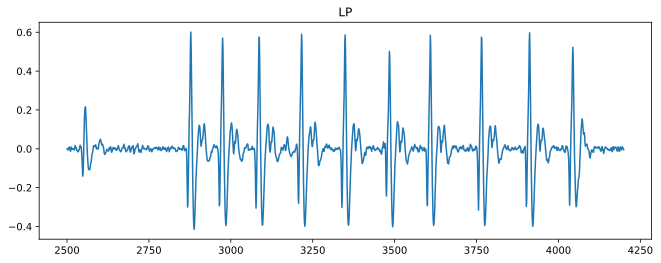

In [79]:
a = 2500
b = 4200
plt.figure(figsize = (11, 4))
plt.title("LP")
plt.plot(trozoC.iloc[a:b, 0])
plt.show()

Tal y como hicimos originalmente para fijar el umbral cuando codificábamos *spikes*, seguiremos un proceso en dos etapas para fijar cuántos *spikes* consideramos que debe haber como mínimo en un *burst* (a este número lo llamaremos $\rho$). En primer lugar, tras el análisis visual y estadístico de los datos y las distancias entre *spikes* que hicimos antes, fijamos un valor *a priori* de $\rho_0=6.$ En base a este valor vamos a elegir un tamaño de ventana adecuado. El razonamiento que hacemos es el siguiente: tomamos para cada serie (LP y VD) las medianas de las distancias entre picos consecutivos, y hacemos la media de los dos valores obtenidos$^{(\ast)}$. Para encontrar *bursts*, que hemos dicho que como mínimo tendrían $6$ *spikes*, necesitaríamos tomar un tamaño de ventana de $6$ veces la estimación realizada. Además de esto, multiplicamos la mediana por un factor corrector de $1.5$ para dejar más márgen de encontrar *bursts* de mayor longitud.

$^{(\ast)}$Utilizamos la mediana en vez de la media por ser más robusta a *outliers*. La suposición general que hacemos es que los *spikes* vienen mayormente en grupos o *bursts*, de forma mucho más frecuente que aislados. Por esto tiene sentido utilizar la mediana como medida estadística relevante para decidir el tamaño de ventana.

In [80]:
trozoC_t = filter_with_threshold(trozoC, threshold)
peaks = get_peaks(trozoC_t)
spikes_per_burst_priori = 6
dist_arr = [np.diff(ps) for ps in peaks]
window_burst = spikes_per_burst_priori * np.mean([1.5 * np.median(d) 
                                                  for d in dist_arr])
print("Ventana a priori para medir bursts:", window_burst)

Ventana a priori para medir bursts: 1444.5


Usando este tamaño de ventana, vamos a decidir cuál es el valor *a posteriori* del número de *spikes* por *burst* que vamos a fijar. Para ello, calculamos para el tamaño de ventana fijado cuántos spikes caen en cada bin (únicamente cuando al menos cae un *spike* en ese bin), y hacemos la media de la distribución obtenida. Finalmente, aplicamos un factor corrector a este valor, y el resultado redondeado al alza será el número de *spikes* que consideramos que hay como mínimo en un *burst*.

In [81]:
def compute_spikes_per_burst(df, threshold, window_burst):
    """ Calcula el número mínimo de spikes por burst en base a un umbral y
        un tamaño de ventana fijo, calculando la media de spikes que
        caen en cada ventana. """
    
    df_t = filter_with_threshold(df, threshold)
    peaks = get_peaks(df_t)
    df_w = np.array([apply_window(df_t.shape[0], peaks[i], window_burst) 
                     for i in [0, 1]])
    unique, count = np.unique(df_w, return_counts = True)
        
    return math.ceil(np.sum(unique * count) / np.sum(count[1:]))

In [82]:
spikes_per_burst = compute_spikes_per_burst(trozoC, threshold, window_burst)
print("Número mínimo de spikes por burst:", spikes_per_burst)

Número mínimo de spikes por burst: 6


Vemos que se mantiene el número mínimo de *spikes* que fijamos inicialmente. Podemos calcular la información mutua y la transferencia de información de la serie con los parámetros fijados hasta el momento; es decir, la ventana preliminar y el número mínimo de *spikes* por *burst*. Para ello definimos una función que nos permita codificar la presencia de *bursts* como eventos de interés.

In [83]:
def codify_bursts(df_t, window, peaks, spikes_per_burst):
    """ Convierte una serie binaria en una serie de bursts, fijando un
        tamaño de ventana y un número mínimo de spikes por burst. """
    
    df_w = np.array([apply_window(df_t.shape[0], peaks[i], window) 
                     for i in [0, 1]])
        
    return np.array(filter_with_threshold(pd.DataFrame(df_w), spikes_per_burst))

Calculamos ya la información mutua y la transferencia de información variando el tamaño de palabra.

Tiempo total para estrategia from_entropy: 1.3s


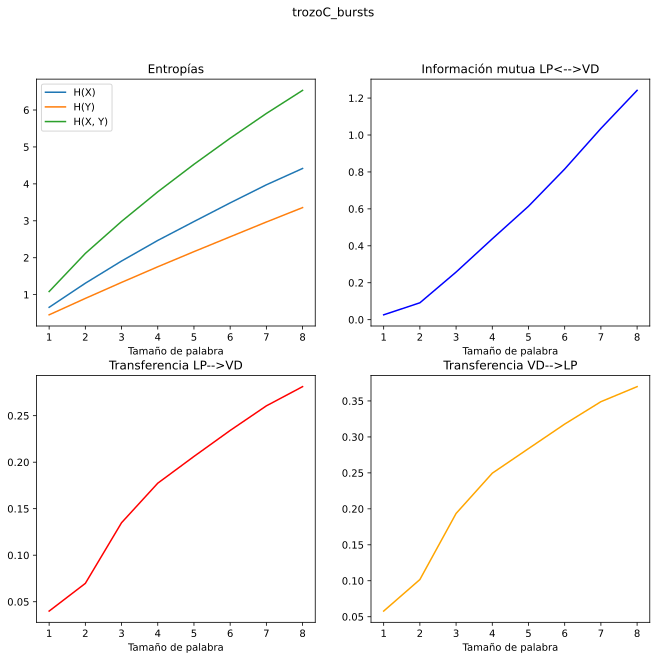

In [64]:
bs = np.arange(1, 9, 1)
trozoC_w_bursts = codify_bursts(trozoC_t, window_burst, peaks, 
                                spikes_per_burst)
Ms, TXYs, TYXs, HsX, HsY = compute_info(trozoC_w_bursts, bs, "from_entropy", 
                                        "trozoC_bursts", verbose = False)
plot_info("trozoC_bursts", bs, Ms, HsX, HsY, TXYs, TYXs)

Vemos que la información mutua evoluciona frente al tamaño de palabra de la misma forma que lo hacía cuando codificábamos *spikes*, es decir, aumenta conforme crece el tamaño de palabra. En este caso la diferencia es que el valor de la entropía es unas 10 veces mayor que en el caso anterior. 

En cuanto a la transferencia de información, se sigue manteniendo que la transferencia $VD\to LP$ es ligeramente mayor que la $LP \to VD$. Sin embargo, en este caso ambas transferencias de información son crecientes con el tamaño de palabra; no llegan a un punto de saturación en el rango de bits estudiado. Es decir, a mayor tamaño de palabra, mayor transferencia de información con bursts.

Tal y como hicimos antes, estudiamos ahora cómo evolucionan las medidas de información conforme vamos variando el tamaño de bin. En este caso exploramos desde 5 hasta 10000, incrementando de 25 en 25 cada vez.

In [88]:
def process_word_burst(b, n, df_t, peaks, spikes_per_burst):
    """ Calcula la información mutua variando el tamaño de ventana, para un 
        número fijo 'b' de bits de palabra. En este caso los eventos que 
        llevan la información son los bursts. """
    
    MIs = []
    for w in np.arange(5, n + 1, 25):
        df_w = codify_bursts(trozoC_t, w, peaks, spikes_per_burst)
        MIs.append(MI_and_H(df_w, [b])[0][0])
        
    return MIs, b

In [87]:
n = 10000

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores) \
        (delayed(process_word_burst)(b, n, trozoC_t, peaks, spikes_per_burst) 
           for b in bs)

KeyboardInterrupt: 

Exploramos gráficamente los resultados.

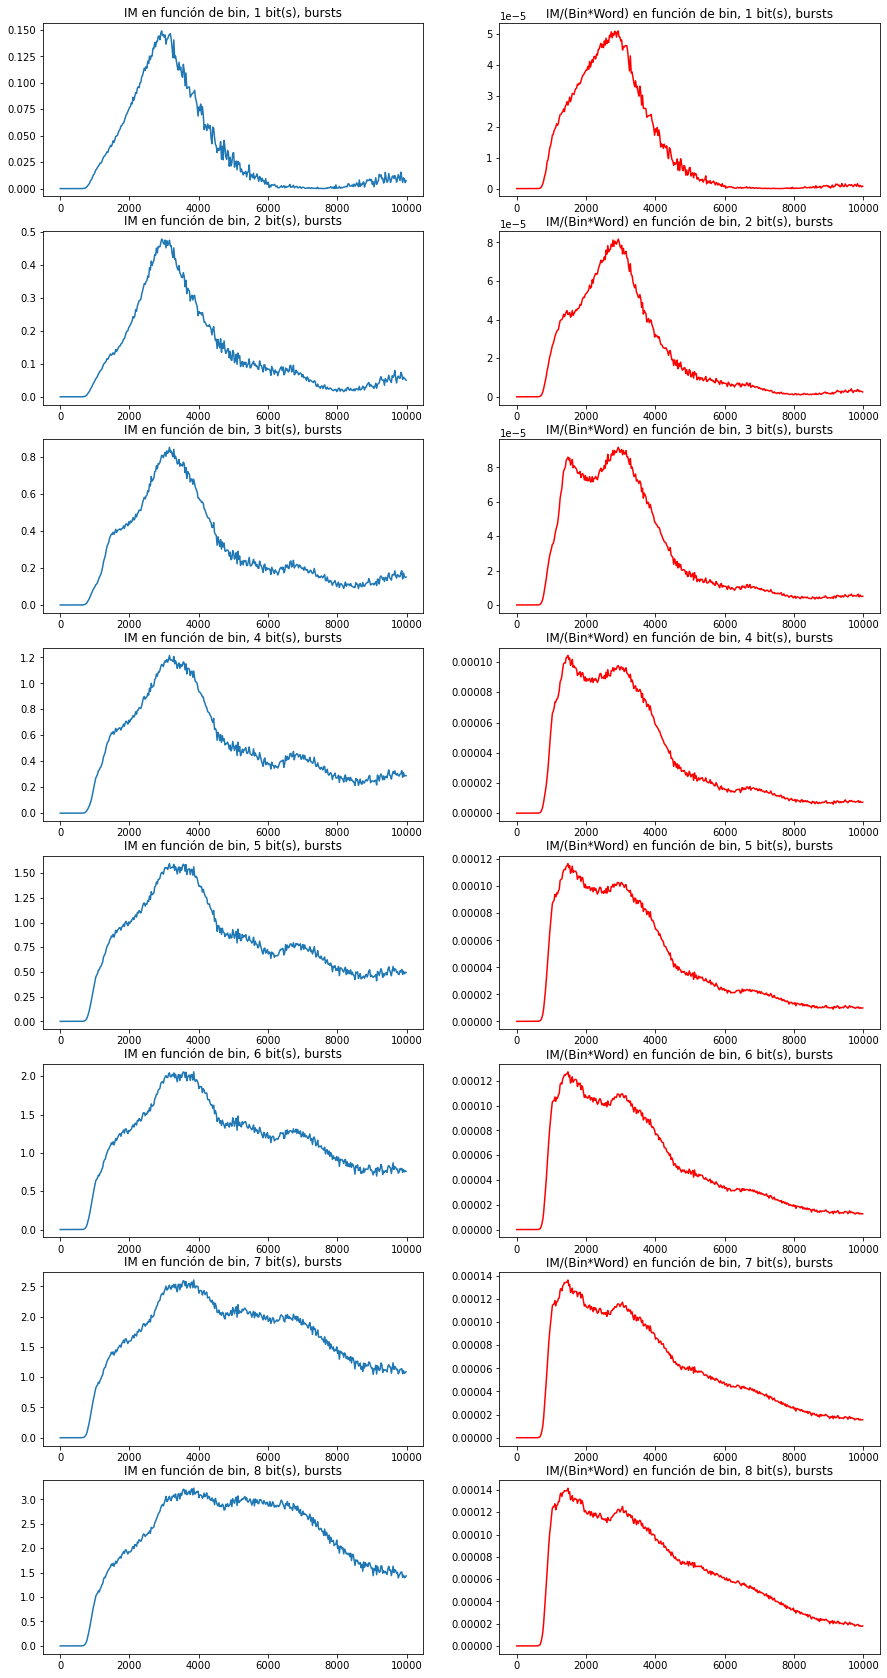

In [59]:
fig, axs = plt.subplots(8, 2, figsize = (16, 24))
for i, r in enumerate(results):
    b = r[1]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s), bursts")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s), bursts")
        
    axs[i, 0].plot(np.arange(5, n + 1, 25), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 25), 
                   r[0] / (np.arange(5, n + 1, 25) * b), color = "red")

En este caso vemos como el comportamiento de la información mutua y la información mutua normalizada es más parecido. Concretamente, en ambos casos se llega a un punto máximo de información mutua, y después comienza a decrecer. Podemos observar como este punto tarda más en alcanzarse conforme más aumenta el tamaño de palabra, y el descenso de la información mutua es menos pronunciado. 

Por otro lado, la información mutua aumenta de forma absoluta conforme aumenta el tamaño de palabra, alcanzando su valor máximo (con $8$ bits) en torno a 3. Podríamos decir que el tamaño de palabra que más hace crecer la información mutua es $b=8$, y dentro de ese tamaño, el tamaño de bin que la maximiza estaría entre $3000$ y $4000$.

Podemos observar que con esta codificación se consiguen valores más altos de información mutua, y además, el tiempo de ejecución es considerablemente menor, ya que reducimos mucho el tamaño de la serie (las ventanas son mayores).

## Estudio de TrozoG

Acabado el estudio del primer trozo, acometemos el estudio de los dos restantes. Repetiremos los pasos que hemos realizado hasta ahora, pero con menos nivel de detalle, ya que todo el procedimiento es análogo.

Comenzamos mostrando los resultados obtenidos en los *spikes* más próximos utilizando los cómputos por defecto, es decir, el umbral obtenido por el método estadístico y el tamaño de ventana correspondiente a la distancia entre los dos picos más cercanos.

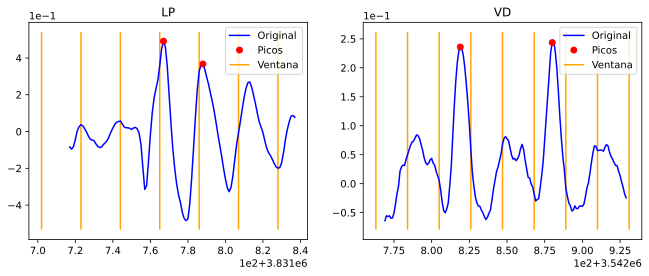

In [92]:
_ = codify_signal(trozoG, plot = True)

Los resultados por defecto parecen adecuados, por lo que los dejamos así. Pasamos a calcular la información mutua en función del bin y del tamaño de palabra, como hemos hecho antes. Mostramos los resultados gráficamente.

In [68]:
threshold = compute_threshold(trozoG)
trozoG_t = filter_with_threshold(trozoG, threshold)
peaks = get_peaks(trozoG_t)
n = 600
bs = np.arange(1, 9)

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores) \
      (delayed(process_word)(b, n, trozoG_t, peaks) for b in bs)

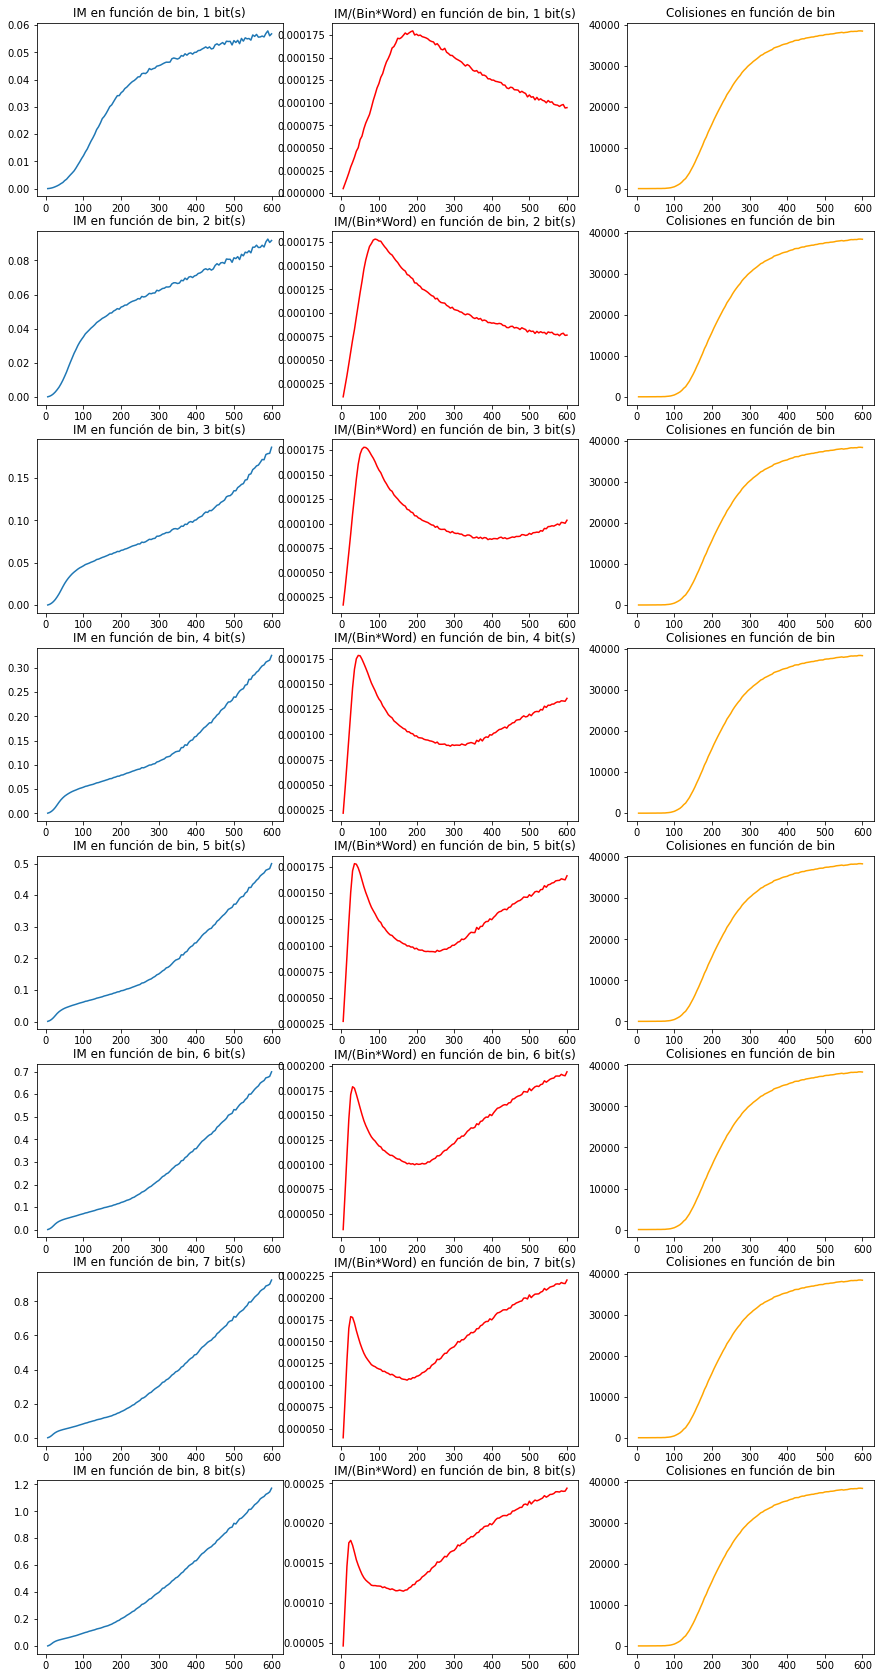

In [63]:
fig, axs = plt.subplots(8, 3, figsize = (16, 24))
for i, r in enumerate(results):
    b = r[2]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s)")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s)")
    axs[i, 2].set_title(f"Colisiones en función de bin")
        
    axs[i, 0].plot(np.arange(5, n + 1, 5), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 5), r[0] /(np.arange(5, n + 1, 5) * b), 
                   color = "red")
    axs[i, 2].plot(np.arange(5, n + 1, 5), r[1], color = "orange")

**Conclusiones de esto**

Realizamos el mismo procedimiento pero ahora utilizando la codificación en *bursts*.

In [66]:
n = 10000

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores) \
      (delayed(process_word_burst)(b, n, trozoG_t, peaks, spikes_per_burst) 
                for b in bs)

NameError: name 'trozoG_t' is not defined

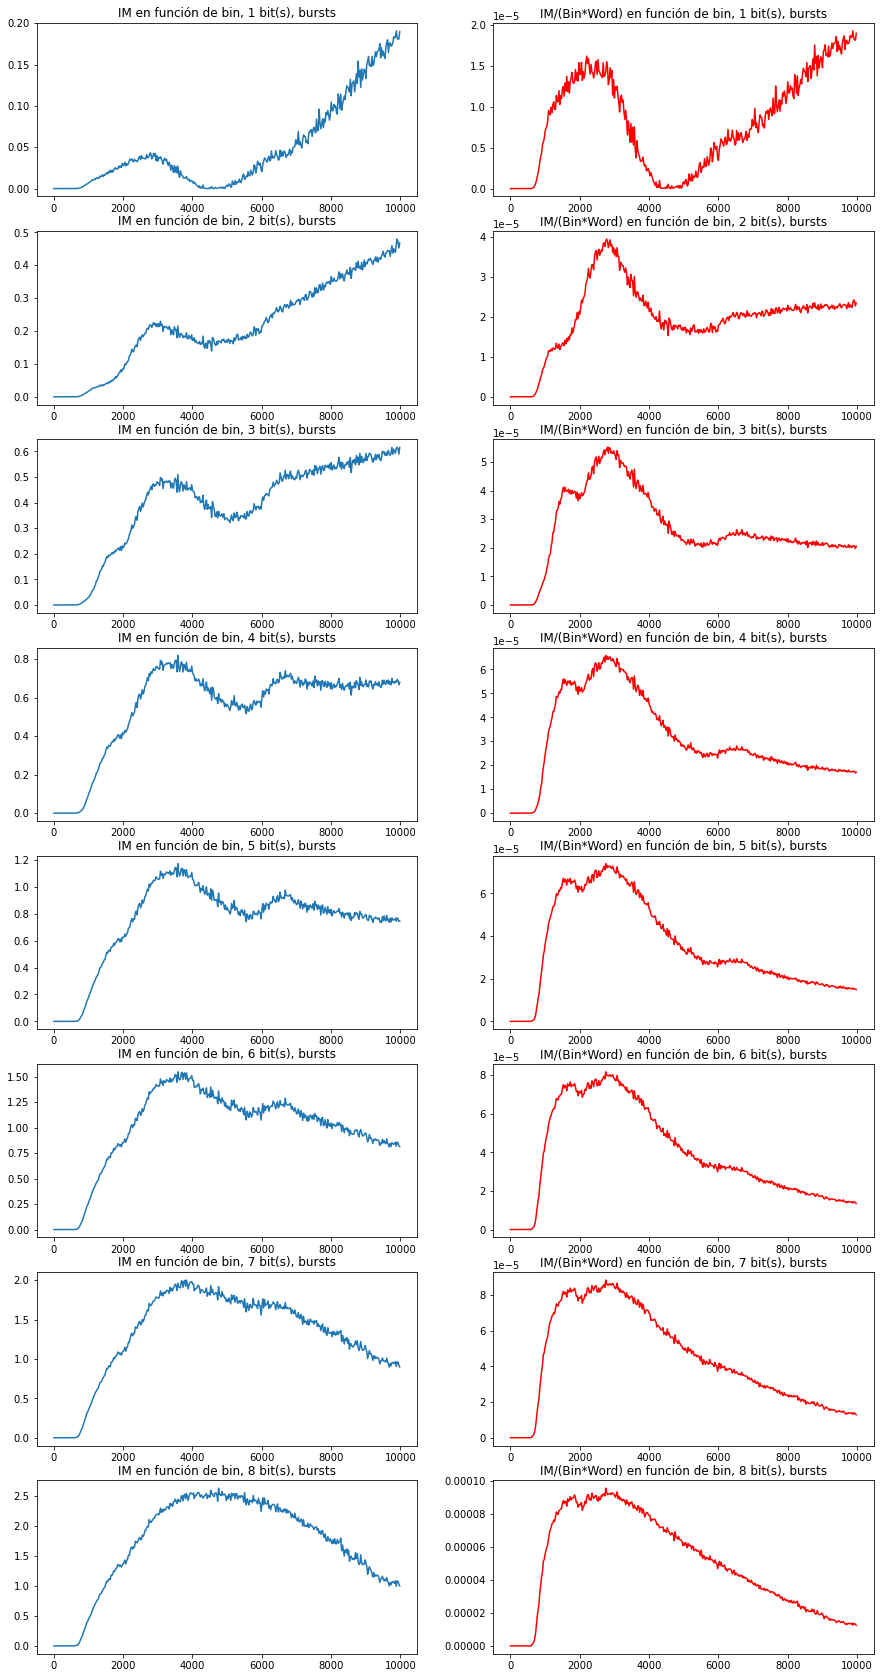

In [70]:
fig, axs = plt.subplots(8, 2, figsize = (16, 24))
for i, r in enumerate(results):
    b = r[1]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s), bursts")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s), bursts")
        
    axs[i, 0].plot(np.arange(5, n + 1, 25), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 25), 
                   r[0] / (np.arange(5, n + 1, 25) * b), color = "red")

**Conclusiones**

## TrozoR

Para el último trozo, correspondiente al estado de recuperación de las neuronas, volvemos a repetir el proceso.

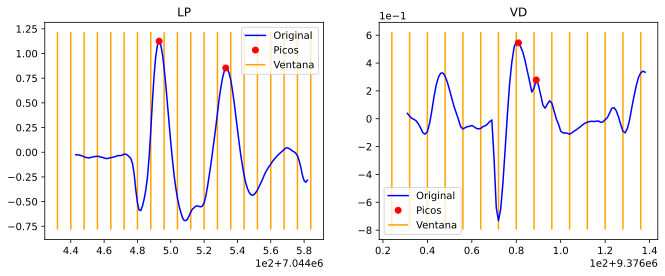

In [93]:
_ = codify_signal(trozoR, plot = True)

En este caso, los valores por defecto de la codificación nos llevan a un resultado no deseado, debido a que el valor del umbral hace que se encuentren en la serie VD dos picos muy cercanos (que realmente forman parte del mismo *spike*). Para solucionarlo, aumentamos ligeramente el valor del umbral hasta solucionar el problema.

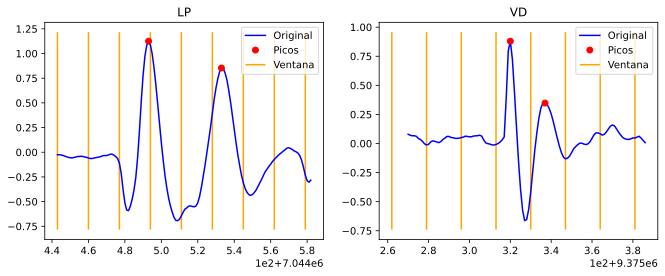

In [94]:
_ = codify_signal(trozoR, 
                         threshold = [compute_threshold(trozoR)[0], 0.3], 
                         plot = True)

Una vez que estamos satisfechos con el umbral escogido, pasamos a calcular la información mutua y la transferencia de información, variando de nuevo el tamaño de bin y el tamaño de palabra.

In [65]:
threshold = [compute_threshold(trozoR)[0], 0.3]
trozoR_t = filter_with_threshold(trozoR, threshold)
peaks = get_peaks(trozoR_t)
n = 600
bs = np.arange(1, 9)

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores) \
      (delayed(process_word)(b, n, trozoR_t, peaks) for b in bs)

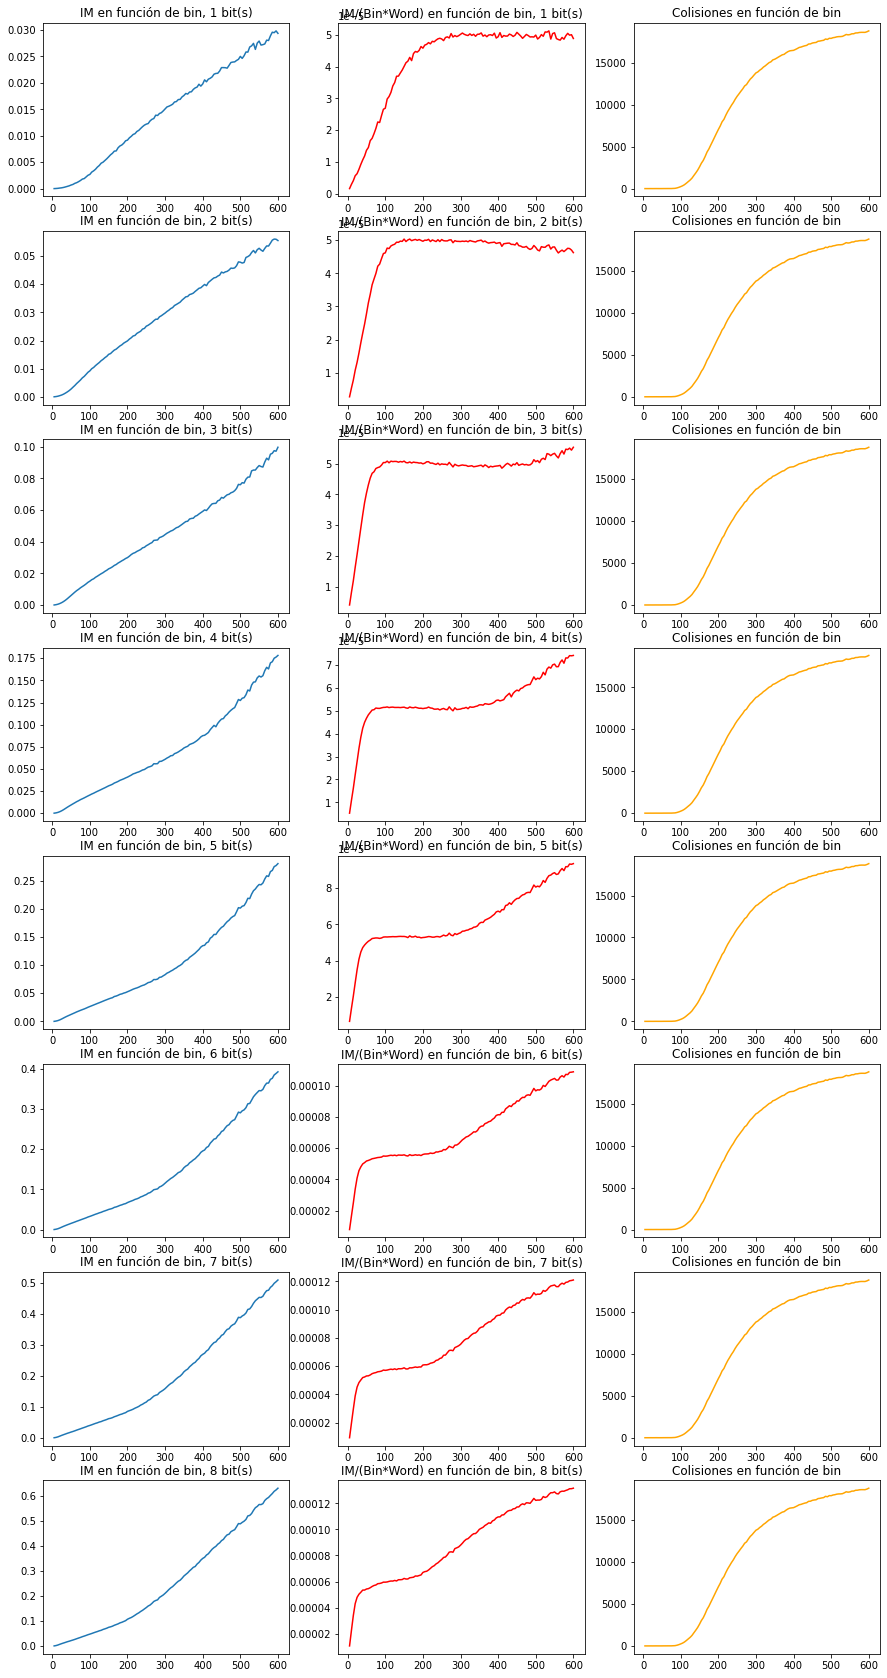

In [61]:
fig, axs = plt.subplots(8, 3, figsize = (16, 24))
for i, r in enumerate(results):
    b = r[2]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s)")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s)")
    axs[i, 2].set_title(f"Colisiones en función de bin")
        
    axs[i, 0].plot(np.arange(5, n + 1, 5), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 5), r[0] /(np.arange(5, n + 1, 5) * b), 
                   color = "red")
    axs[i, 2].plot(np.arange(5, n + 1, 5), r[1], color = "orange")

**Conclusiones**

Finalmente, cambiamos la codificación para tener en cuenta los *bursts*, y repetimos el proceso.

In [66]:
n = 10000

# Parallel execution for each word size
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(tqdm(total = len(bs))) as progress_bar:
    results = Parallel(n_jobs = num_cores) \
      (delayed(process_word_burst)(b, n, trozoR_t, peaks, spikes_per_burst) 
                for b in bs)

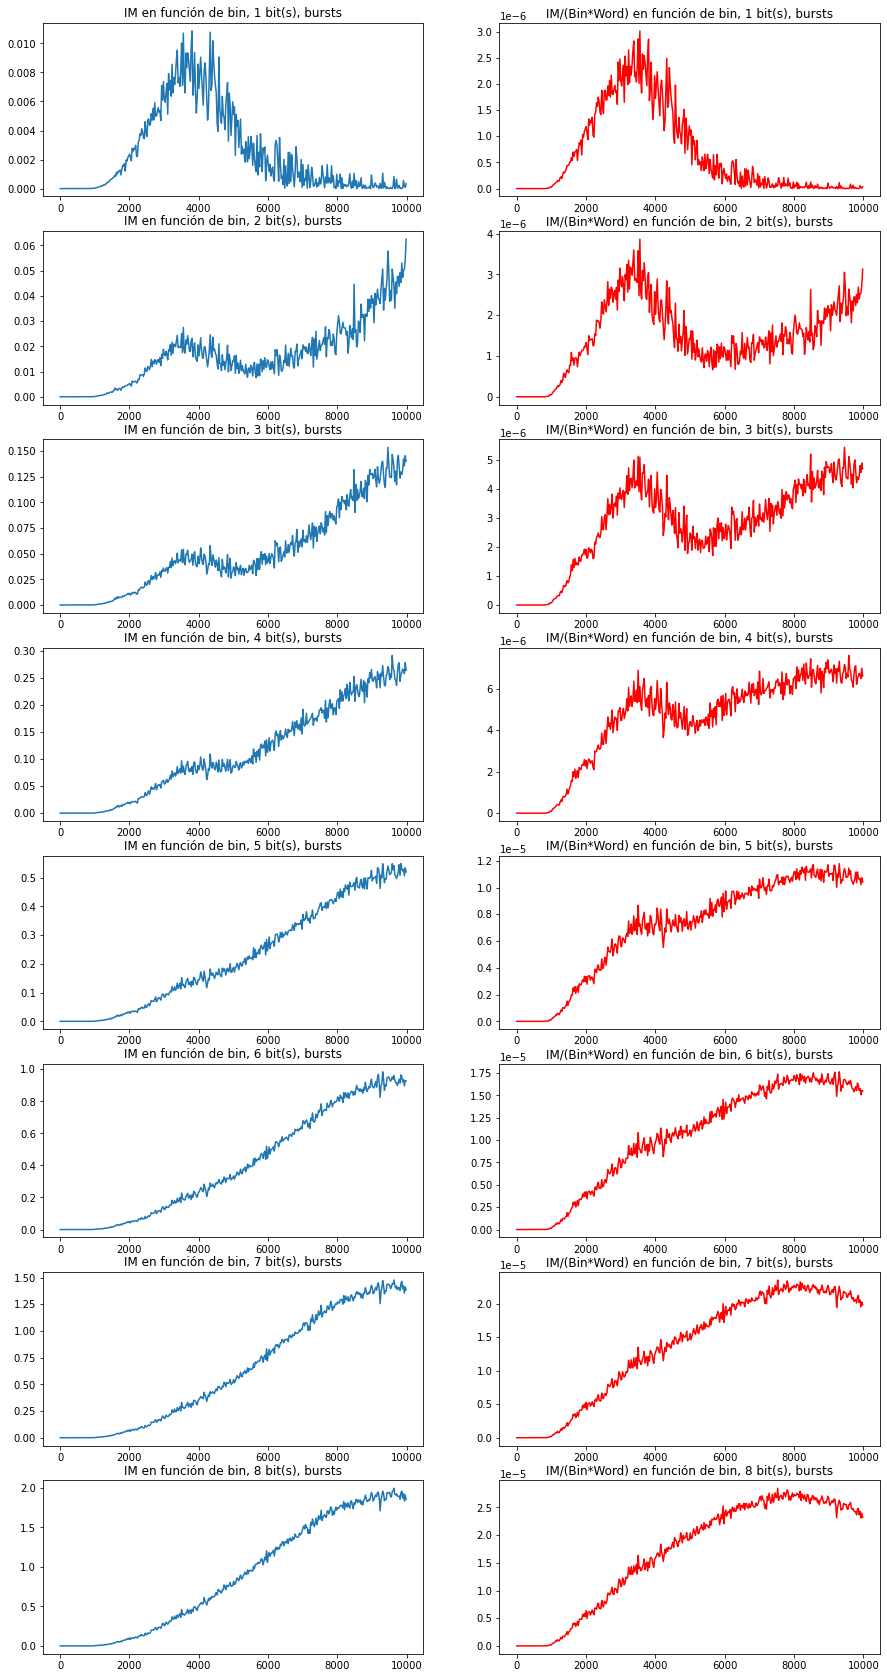

In [67]:
fig, axs = plt.subplots(8, 2, figsize = (16, 24))
for i, r in enumerate(results):
    b = r[1]
    axs[i, 0].set_title(f"IM en función de bin, {b} bit(s), bursts")
    axs[i, 1].set_title(f"IM/(Bin*Word) en función de bin, {b} bit(s), bursts")
        
    axs[i, 0].plot(np.arange(5, n + 1, 25), r[0])
    axs[i, 1].plot(np.arange(5, n + 1, 25), 
                   r[0] / (np.arange(5, n + 1, 25) * b), color = "red")

**Conclusiones**

## Conclusiones

- los bursts tienen más información que los spikes
- Comportamiento diferente en los tres trozos. similitudes. diferencias.
- cuidado con la ventana y el umbral. puntos de saturación.
- codificación muy importante. técnicas estadísticas.
- IM aumenta con tamaño de palabra
- tiempo de ejecución importante. cálculos vectorizados. poner tiempo total de ejecución del notebook y caracteristicas del pc.
- existen otros tipos de codificación (sax...)